In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a files and split into lines
def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/French.txt', 'data/names/Czech.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt', 'data/names/Greek.txt']
Slusarski


In [2]:
print(category_lines["Italian"][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [4]:
import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def lineToTensor(line):
  tensor = torch.rand(len(line), 1, n_letters)
  for i, letter in enumerate(line):
    tensor[i][0][letterToIndex(letter)] = 1
  return tensor

print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.5633, -2.9245, -2.9652, -2.8197, -3.1873, -2.7893, -2.8832, -3.0532,
         -3.0538, -2.7640, -2.8717, -2.8840, -2.7250, -3.0743, -3.0482, -2.8282,
         -2.8417, -2.9416]], grad_fn=<LogSoftmaxBackward0>)


In [19]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 1)


In [13]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category = ', category, '/ line = ', line)

category =  Russian / line =  Mojaiskov
category =  English / line =  Noggins
category =  Irish / line =  Kavanagh
category =  Scottish / line =  Munro
category =  Portuguese / line =  Mendes
category =  Russian / line =  Glebovich
category =  Korean / line =  Shin
category =  Japanese / line =  Kajitani
category =  Scottish / line =  Gibson
category =  Greek / line =  Vourlis


In [14]:
criterion = nn.NLLLoss()

In [21]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  # Add parameters' gradients to their values, multiplied by learning rate
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [22]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 11s) 2.9590 Yamato / Arabic ✗ (Japanese)
10000 10% (0m 23s) 1.8257 Agudov / Russian ✓
15000 15% (0m 34s) 2.4865 Colbert / Portuguese ✗ (French)
20000 20% (0m 45s) 7.2385 Re / Korean ✗ (Italian)
25000 25% (0m 57s) 2.9170 Matos / Greek ✗ (Portuguese)
30000 30% (1m 8s) 2.2884 Chaput / Arabic ✗ (French)
35000 35% (1m 19s) 3.5521 Slazak / Irish ✗ (Polish)
40000 40% (1m 30s) 2.5848 Murray / Arabic ✗ (Scottish)
45000 45% (1m 43s) 1.3730 Ungaretti / Italian ✓
50000 50% (1m 54s) 3.0938 Manos / Arabic ✗ (Greek)
55000 55% (2m 6s) 2.8411 Marek / German ✗ (Polish)
60000 60% (2m 17s) 2.5861 Mooren / Irish ✗ (Dutch)
65000 65% (2m 29s) 1.7388 Bellandi / Polish ✗ (Italian)
70000 70% (2m 40s) 2.3604 Said / Portuguese ✗ (Arabic)
75000 75% (2m 52s) 2.6807 Tupihin / Irish ✗ (Russian)
80000 80% (3m 2s) 3.2413 Idoni / Vietnamese ✗ (Italian)
85000 85% (3m 13s) 3.2983 Magalhaes / Polish ✗ (Portuguese)
90000 90% (3m 25s) 2.8115 Madden / Dutch ✗ (Irish)
95000 95% (3m 36s) 3.6519 Brand / Scottish ✗ (G

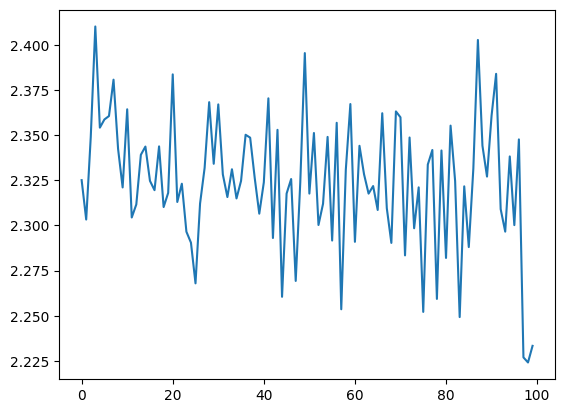

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-24-c9df9b322989>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-24-c9df9b322989>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


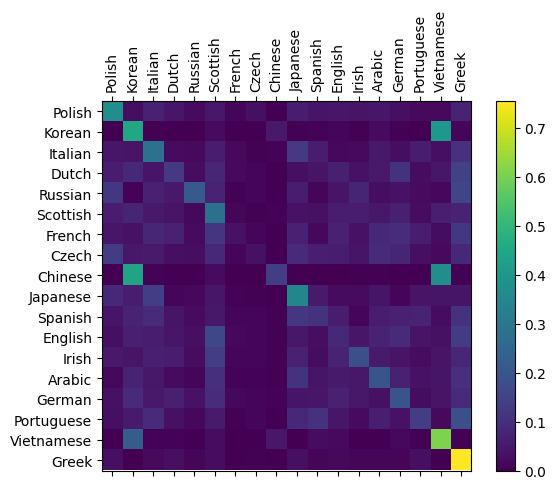

In [24]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


In [26]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)

  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.831108) Italian
(-1.831904) Polish
(-2.153741) Scottish

> Jackson
(-1.719196) Portuguese
(-2.022336) Scottish
(-2.369223) Dutch

> Satoshi
(-1.534341) Greek
(-2.092189) Polish
(-2.209274) Italian
